# Regularization - Ridge & Lasso Under the Hood
## Understanding L1 and L2 Regularization from Scratch

---

## 🎯 Learning Goals

This notebook demonstrates:

1. **Overfitting** - How it appears in polynomial regression with increasing model complexity

2. **Ridge (L2) Regularization** - How it modifies the loss function to prevent overfitting
   - $J_{ridge}(w, b) = \frac{1}{n} ||y - (Xw + b)||^2 + \lambda ||w||^2$

3. **λ (Lambda) Effect** - How increasing λ shrinks coefficients toward zero

4. **Closed-Form Solution** - How to compute Ridge regression analytically

5. **Lasso (L1) Regularization** - Conceptual differences and sparsity-inducing properties

---

## ⚙️ Implementation Rules

✅ **Allowed:**
- `numpy`, `pandas`, `matplotlib`, `ipywidgets` for core implementation
- `sklearn` **only for validation/comparison** at the end

❌ **Not Allowed in Core Logic:**
- `sklearn.linear_model.Ridge` as main method
- `sklearn.preprocessing.PolynomialFeatures` (we build features manually)

**All core computations are implemented explicitly with NumPy!**

## 1. Imports & Configuration

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configure matplotlib defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Fix random seed for reproducibility
np.random.seed(42)

print("✅ Libraries loaded successfully!")
print("✅ Implementing Ridge regularization from scratch using NumPy")

✅ 라이브러리 불러오기 완료! / Libraries loaded successfully!
✅ NumPy를 사용하여 Ridge 정규화를 처음부터 구현합니다.
✅ We will implement Ridge regularization from scratch using NumPy.


## 2. Data Generation

Generate 1D input data with a nonlinear relationship plus noise.

In [ ]:
def generate_poly_data(n_samples=50, noise_std=0.3, seed=42):
    """
    Generate 1D polynomial data with nonlinear relationship.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples
    noise_std : float
        Standard deviation of noise
    seed : int
        Random seed
    
    Returns:
    --------
    x_raw : np.ndarray, shape (n_samples,)
        1D input data
    y : np.ndarray, shape (n_samples,)
        Noisy target values
    """
    np.random.seed(seed)
    
    # Sample x_raw uniformly from [-3, 3]
    x_raw = np.linspace(-3, 3, n_samples)
    
    # True function: y_true = sin(x) + 0.3*x (nonlinear relationship)
    y_true = np.sin(x_raw) + 0.3 * x_raw
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, n_samples)
    y = y_true + noise
    
    return x_raw, y


# Generate data
x_raw, y = generate_poly_data(n_samples=50, noise_std=0.3)

print(f"✅ Data generated: x shape={x_raw.shape}, y shape={y.shape}")

📊 생성된 데이터 (처음 5개) / Generated data (first 5 rows):
          x         y
0 -3.000000 -0.892106
1 -2.877551 -1.165729
2 -2.755102 -1.009164
3 -2.632653 -0.820138
4 -2.510204 -1.413573

데이터 형태 / Data shape: x=(50,), y=(50,)


/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/3237336077.py:9: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/3237336077.py:9: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/3237336077.py:9: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/3237336077.py:9: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/3237336077.py:9: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel

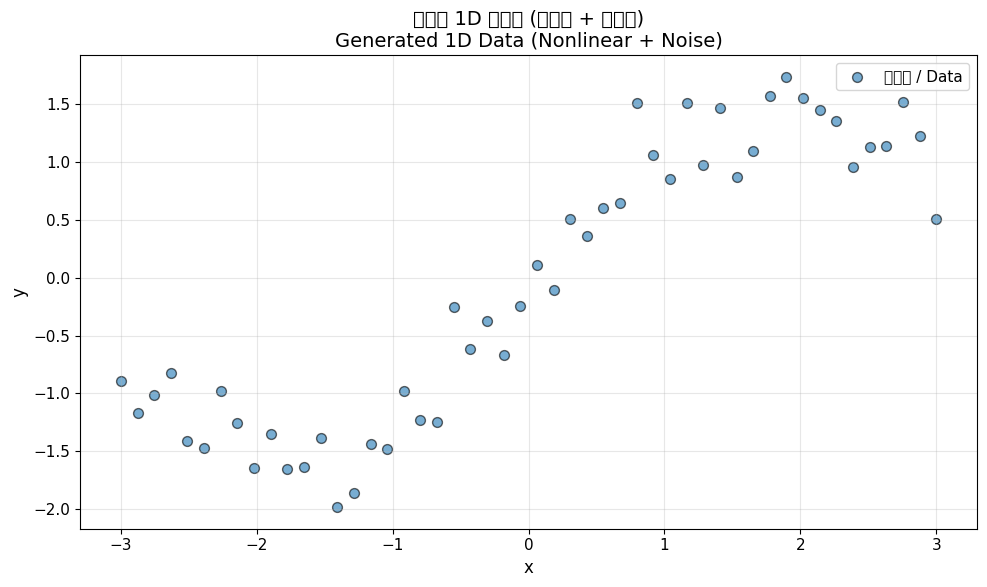

✅ 데이터는 비선형 패턴을 가지며 노이즈가 포함되어 있습니다.
✅ The data has a nonlinear pattern with added noise.


In [ ]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x_raw, y, alpha=0.6, s=50, edgecolors='k', label='Data')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Generated 1D Data (Nonlinear + Noise)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Polynomial Feature Construction (Manual Implementation)

We manually create polynomial features with NumPy without sklearn.

In [4]:
def make_poly_features(x_raw, degree):
    """
    1D 입력에서 다항식 특징을 생성합니다 (sklearn 없이).
    Generate polynomial features from 1D input (without sklearn).
    
    Parameters:
    -----------
    x_raw : np.ndarray, shape (n,)
        1D 입력 데이터 / 1D input data
    degree : int
        다항식 차수 / Polynomial degree
    
    Returns:
    --------
    X_poly : np.ndarray, shape (n, degree)
        다항식 특징 행렬: [x, x^2, x^3, ..., x^degree]
        Polynomial feature matrix: [x, x^2, x^3, ..., x^degree]
    """
    n = len(x_raw)
    X_poly = np.zeros((n, degree))
    
    # 각 차수에 대해 x^j를 계산 / Compute x^j for each degree j
    for j in range(1, degree + 1):
        X_poly[:, j-1] = x_raw ** j
    
    return X_poly


# 4차 다항식 특징 생성 (과적합이 나타날 수 있도록)
# Generate degree-4 polynomial features (to show overfitting)
degree = 4
X_poly = make_poly_features(x_raw, degree)

print(f"✅ 다항식 특징 생성 완료! / Polynomial features created!")
print(f"   차수 (degree) = {degree}")
print(f"   특징 행렬 형태 / Feature matrix shape: {X_poly.shape}")
print()

# DataFrame으로 확인 / Display as DataFrame
col_names = [f'x^{j}' for j in range(1, degree+1)]
df_poly = pd.DataFrame(X_poly, columns=col_names)
print("📊 다항식 특징 (처음 5개) / Polynomial features (first 5 rows):")
print(df_poly.head())

✅ 다항식 특징 생성 완료! / Polynomial features created!
   차수 (degree) = 4
   특징 행렬 형태 / Feature matrix shape: (50, 4)

📊 다항식 특징 (처음 5개) / Polynomial features (first 5 rows):
        x^1       x^2        x^3        x^4
0 -3.000000  9.000000 -27.000000  81.000000
1 -2.877551  8.280300 -23.826985  68.563366
2 -2.755102  7.590587 -20.912842  57.617015
3 -2.632653  6.930862 -18.246555  48.036850
4 -2.510204  6.301125 -15.817109  39.704170


## 4️⃣ 정규화 없는 OLS (일반 최소제곱법) / Unregularized OLS (Ordinary Least Squares)

먼저 정규화 없이 다항 회귀를 학습하여 **과적합**을 확인합니다.
First, we train polynomial regression without regularization to observe **overfitting**.

In [5]:
def fit_linreg_closed_form(X, y):
    """
    OLS 선형회귀를 닫힌 형태로 학습합니다 (정규화 없음).
    Fit OLS linear regression in closed form (no regularization).
    
    손실 함수 / Loss function:
        J(w, b) = (1/n) * ||y - (Xw + b)||^2
    
    정규 방정식 / Normal equation:
        (X_bias^T X_bias) θ = X_bias^T y
        여기서 X_bias = [1, X], θ = [b, w]
        where X_bias = [1, X], θ = [b, w]
    
    Parameters:
    -----------
    X : np.ndarray, shape (n, d)
        특징 행렬 / Feature matrix
    y : np.ndarray, shape (n,)
        타겟 벡터 / Target vector
    
    Returns:
    --------
    b_hat : float
        절편 / Intercept
    w_hat : np.ndarray, shape (d,)
        계수 벡터 / Coefficient vector
    """
    n, d = X.shape
    
    # X_bias = [1, X] (첫 열에 1을 추가)
    # X_bias = [1, X] (add column of ones)
    ones = np.ones((n, 1))
    X_bias = np.hstack([ones, X])
    
    # 정규 방정식: A θ = b_vec
    # Normal equation: A θ = b_vec
    A = X_bias.T @ X_bias
    b_vec = X_bias.T @ y
    
    # np.linalg.solve로 해 구하기 (inv보다 안정적)
    # Solve using np.linalg.solve (more stable than inv)
    theta = np.linalg.solve(A, b_vec)
    
    # θ = [b, w_1, ..., w_d]
    b_hat = theta[0]
    w_hat = theta[1:]
    
    return b_hat, w_hat


def predict_poly(b, w, X_poly):
    """
    다항 회귀 예측 / Polynomial regression prediction
    
    y_hat = b + X_poly @ w
    """
    return b + X_poly @ w


# OLS로 학습 / Train with OLS
b_ols, w_ols = fit_linreg_closed_form(X_poly, y)

print("✅ OLS 학습 완료! / OLS training complete!")
print(f"   절편 (intercept) b = {b_ols:.4f}")
print(f"   계수 (coefficients) w = {w_ols}")
print()
print("⚠️  높은 차수의 다항식은 과적합될 수 있습니다!")
print("⚠️  High-degree polynomials may overfit the data!")

✅ OLS 학습 완료! / OLS training complete!
   절편 (intercept) b = -0.1271
   계수 (coefficients) w = [ 1.21075480e+00  2.18739297e-02 -1.08933765e-01 -5.02283377e-04]

⚠️  높은 차수의 다항식은 과적합될 수 있습니다!
⚠️  High-degree polynomials may overfit the data!


/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/302195181.py:17: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/302195181.py:17: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/302195181.py:17: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/302195181.py:17: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/302195181.py:17: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20

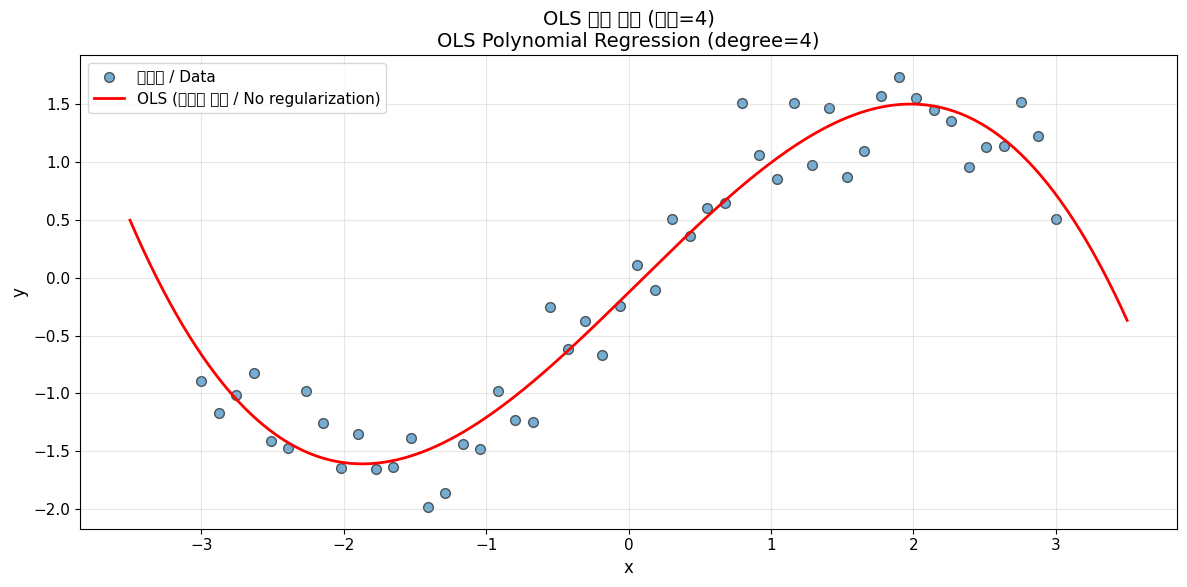

📌 관찰: OLS 곡선이 데이터에 과하게 맞춰질 수 있습니다 (과적합).
📌 Observation: The OLS curve may fit the data too closely (overfitting).


In [6]:
# 시각화를 위한 조밀한 그리드 생성 / Create dense grid for visualization
x_grid = np.linspace(-3.5, 3.5, 300)
X_grid_poly = make_poly_features(x_grid, degree)

# OLS 예측 / OLS predictions
y_ols_pred = predict_poly(b_ols, w_ols, X_grid_poly)

# 시각화 / Visualization
plt.figure(figsize=(12, 6))
plt.scatter(x_raw, y, alpha=0.6, s=50, edgecolors='k', label='데이터 / Data')
plt.plot(x_grid, y_ols_pred, 'r-', linewidth=2, label='OLS (정규화 없음 / No regularization)')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('OLS 다항 회귀 (차수=4)\nOLS Polynomial Regression (degree=4)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📌 관찰: OLS 곡선이 데이터에 과하게 맞춰질 수 있습니다 (과적합).")
print("📌 Observation: The OLS curve may fit the data too closely (overfitting).")

### 🔍 sklearn과 비교 (OLS) / Compare with sklearn (OLS)

In [7]:
# sklearn LinearRegression과 비교 / Compare with sklearn LinearRegression
from sklearn.linear_model import LinearRegression

sklearn_ols = LinearRegression()
sklearn_ols.fit(X_poly, y)

print("="*60)
print("✅ OLS 검증 / OLS Validation")
print("="*60)
print(f"우리 구현 (Our implementation):")
print(f"  절편 (intercept) = {b_ols:.6f}")
print(f"  계수 (coef)      = {w_ols}")
print()
print(f"sklearn LinearRegression:")
print(f"  절편 (intercept) = {sklearn_ols.intercept_:.6f}")
print(f"  계수 (coef)      = {sklearn_ols.coef_}")
print()
print("📌 두 구현의 결과가 거의 동일합니다!")
print("📌 The results from both implementations are nearly identical!")

✅ OLS 검증 / OLS Validation
우리 구현 (Our implementation):
  절편 (intercept) = -0.127132
  계수 (coef)      = [ 1.21075480e+00  2.18739297e-02 -1.08933765e-01 -5.02283377e-04]

sklearn LinearRegression:
  절편 (intercept) = -0.127132
  계수 (coef)      = [ 1.21075480e+00  2.18739297e-02 -1.08933765e-01 -5.02283377e-04]

📌 두 구현의 결과가 거의 동일합니다!
📌 The results from both implementations are nearly identical!


## 5️⃣ Ridge 회귀 (L2 정규화) - 닫힌 형태 해 / Ridge Regression (L2 Regularization) - Closed Form

이제 **Ridge 정규화**를 추가하여 과적합을 방지합니다.
Now we add **Ridge regularization** to prevent overfitting.

### 수학적 정의 / Mathematical Definition

**Ridge 손실 함수 / Ridge loss function:**

$$J_{ridge}(w, b) = \frac{1}{n} ||y - (Xw + b)||^2 + \lambda ||w||^2$$

- **λ (lambda)**: 정규화 강도 (클수록 계수를 더 작게 만듦)
- **λ (lambda)**: Regularization strength (larger = smaller coefficients)

**닫힌 형태 해 / Closed-form solution:**

$$\theta^* = (X_{bias}^T X_{bias} + \Lambda)^{-1} X_{bias}^T y$$

여기서 / where:
- $X_{bias} = [1, X]$ (편향 항 추가 / bias term added)
- $\theta = [b, w_1, ..., w_d]^T$
- $\Lambda$ = 정규화 행렬 (첫 번째 원소는 0, 나머지는 λ) / regularization matrix (first element is 0, rest are λ)

In [8]:
def fit_ridge_closed_form(X, y, lam):
    """
    Ridge 회귀를 닫힌 형태로 학습합니다.
    Fit Ridge regression in closed form.
    
    Ridge 손실 함수 / Ridge loss function:
        J_ridge(w, b) = (1/n) * ||y - (Xw + b)||^2 + λ ||w||^2
    
    정규 방정식 / Normal equation:
        (X_bias^T X_bias + Λ) θ = X_bias^T y
        여기서 Λ는 대각 행렬, Λ[0,0]=0 (편향 비정규화), Λ[j,j]=λ (j≥1)
        where Λ is diagonal, Λ[0,0]=0 (no bias penalty), Λ[j,j]=λ (j≥1)
    
    Parameters:
    -----------
    X : np.ndarray, shape (n, d)
        특징 행렬 / Feature matrix
    y : np.ndarray, shape (n,)
        타겟 벡터 / Target vector
    lam : float
        정규화 강도 λ / Regularization strength λ
    
    Returns:
    --------
    b_hat : float
        절편 / Intercept
    w_hat : np.ndarray, shape (d,)
        계수 벡터 / Coefficient vector
    """
    n, d = X.shape
    
    # X_bias = [1, X] (첫 열에 1을 추가)
    # X_bias = [1, X] (add column of ones)
    ones = np.ones((n, 1))
    X_bias = np.hstack([ones, X])
    
    # A = X_bias^T X_bias
    A = X_bias.T @ X_bias
    
    # 정규화 행렬 Λ 생성 / Build regularization matrix Λ
    # Λ[0,0] = 0 (편향은 정규화하지 않음 / no penalty on bias)
    # Λ[j,j] = λ for j = 1, ..., d
    reg = np.zeros_like(A)
    reg[1:, 1:] = lam * np.eye(d)
    
    # 정규 방정식: (A + reg) θ = X_bias^T y
    # Normal equation: (A + reg) θ = X_bias^T y
    b_vec = X_bias.T @ y
    theta = np.linalg.solve(A + reg, b_vec)
    
    # θ = [b, w_1, ..., w_d]
    b_hat = theta[0]
    w_hat = theta[1:]
    
    return b_hat, w_hat


# 테스트: λ=1.0으로 Ridge 학습 / Test: Train Ridge with λ=1.0
lam_test = 1.0
b_ridge_test, w_ridge_test = fit_ridge_closed_form(X_poly, y, lam_test)

print("✅ Ridge 학습 완료! / Ridge training complete!")
print(f"   λ (lambda) = {lam_test}")
print(f"   절편 (intercept) b = {b_ridge_test:.4f}")
print(f"   계수 (coefficients) w = {w_ridge_test}")
print()
print("📌 Ridge는 계수를 줄여서 과적합을 방지합니다.")
print("📌 Ridge reduces coefficients to prevent overfitting.")

✅ Ridge 학습 완료! / Ridge training complete!
   λ (lambda) = 1.0
   절편 (intercept) b = -0.1264
   계수 (coefficients) w = [ 1.16343674e+00  2.12015903e-02 -1.01836903e-01 -4.25222391e-04]

📌 Ridge는 계수를 줄여서 과적합을 방지합니다.
📌 Ridge reduces coefficients to prevent overfitting.


## 6️⃣ OLS vs Ridge 시각적 비교 (고정된 λ) / Visual Comparison: OLS vs Ridge (Fixed λ)

/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/16609849.py:14: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/16609849.py:14: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/16609849.py:14: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/16609849.py:14: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/16609849.py:14: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/1660

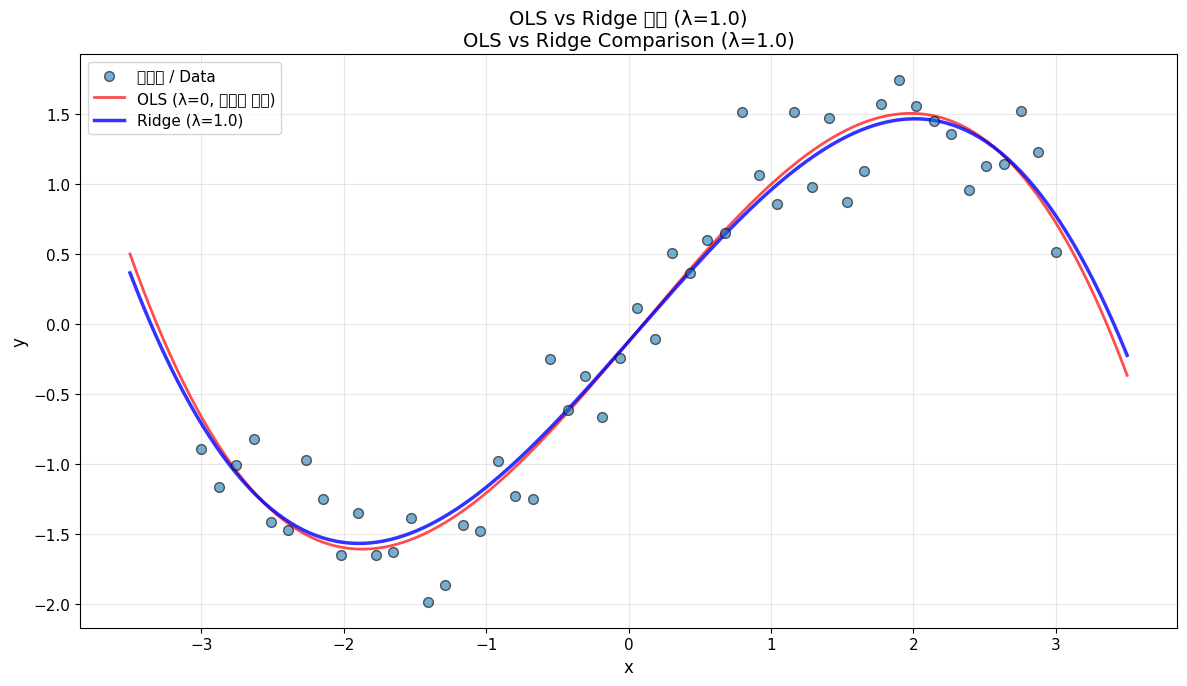

📌 관찰:
   - OLS는 데이터에 과하게 맞춰질 수 있습니다 (빨간색).
   - Ridge는 더 부드러운 곡선을 만듭니다 (파란색).

📌 Observation:
   - OLS may overfit the data (red curve).
   - Ridge produces a smoother curve (blue curve).


In [9]:
# Ridge 예측 / Ridge predictions
y_ridge_test_pred = predict_poly(b_ridge_test, w_ridge_test, X_grid_poly)

# 시각화 / Visualization
plt.figure(figsize=(12, 7))
plt.scatter(x_raw, y, alpha=0.6, s=50, edgecolors='k', label='데이터 / Data', zorder=3)
plt.plot(x_grid, y_ols_pred, 'r-', linewidth=2, label='OLS (λ=0, 정규화 없음)', alpha=0.7)
plt.plot(x_grid, y_ridge_test_pred, 'b-', linewidth=2.5, label=f'Ridge (λ={lam_test})', alpha=0.8)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title(f'OLS vs Ridge 비교 (λ={lam_test})\nOLS vs Ridge Comparison (λ={lam_test})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📌 관찰:")
print("   - OLS는 데이터에 과하게 맞춰질 수 있습니다 (빨간색).")
print("   - Ridge는 더 부드러운 곡선을 만듭니다 (파란색).")
print()
print("📌 Observation:")
print("   - OLS may overfit the data (red curve).")
print("   - Ridge produces a smoother curve (blue curve).")

### 🔍 sklearn과 비교 (Ridge) / Compare with sklearn (Ridge)

In [10]:
# sklearn Ridge와 비교 / Compare with sklearn Ridge
from sklearn.linear_model import Ridge

sklearn_ridge = Ridge(alpha=lam_test, fit_intercept=True)
sklearn_ridge.fit(X_poly, y)

print("="*60)
print(f"✅ Ridge 검증 (λ={lam_test}) / Ridge Validation (λ={lam_test})")
print("="*60)
print(f"우리 구현 (Our implementation):")
print(f"  절편 (intercept) = {b_ridge_test:.6f}")
print(f"  계수 (coef)      = {w_ridge_test}")
print()
print(f"sklearn Ridge:")
print(f"  절편 (intercept) = {sklearn_ridge.intercept_:.6f}")
print(f"  계수 (coef)      = {sklearn_ridge.coef_}")
print()
print("📌 두 구현의 결과가 거의 동일합니다!")
print("📌 The results from both implementations are nearly identical!")

✅ Ridge 검증 (λ=1.0) / Ridge Validation (λ=1.0)
우리 구현 (Our implementation):
  절편 (intercept) = -0.126385
  계수 (coef)      = [ 1.16343674e+00  2.12015903e-02 -1.01836903e-01 -4.25222391e-04]

sklearn Ridge:
  절편 (intercept) = -0.126385
  계수 (coef)      = [ 1.16343674e+00  2.12015903e-02 -1.01836903e-01 -4.25222391e-04]

📌 두 구현의 결과가 거의 동일합니다!
📌 The results from both implementations are nearly identical!


## 7️⃣ 계수 경로 (Coefficient Path): λ가 변할 때 계수의 변화

λ를 증가시키면서 각 계수 $w_j$가 어떻게 변하는지 추적합니다.
Track how each coefficient $w_j$ changes as we increase λ.

In [11]:
def ridge_path_trace(X, y, lam_list):
    """
    여러 λ 값에 대해 Ridge 계수를 추적합니다.
    Track Ridge coefficients for multiple λ values.
    
    Parameters:
    -----------
    X : np.ndarray, shape (n, d)
        특징 행렬 / Feature matrix
    y : np.ndarray, shape (n,)
        타겟 벡터 / Target vector
    lam_list : array-like
        λ 값들의 리스트 / List of λ values
    
    Returns:
    --------
    trace : list of dict
        각 dict는 {"lam": λ, "b": b_hat, "w": w_hat}를 포함
        Each dict contains {"lam": λ, "b": b_hat, "w": w_hat}
    """
    trace = []
    for lam in lam_list:
        b_hat, w_hat = fit_ridge_closed_form(X, y, lam)
        trace.append({"lam": lam, "b": b_hat, "w": w_hat})
    return trace


# λ 값들을 로그 스케일로 생성 / Generate λ values in log scale
lam_list = np.logspace(-4, 3, num=25)

# Ridge 계수 경로 추적 / Trace Ridge coefficient path
ridge_trace = ridge_path_trace(X_poly, y, lam_list)

print(f"✅ {len(lam_list)}개의 λ 값에 대해 계수 경로를 계산했습니다!")
print(f"✅ Computed coefficient paths for {len(lam_list)} λ values!")
print(f"   λ 범위 / λ range: [{lam_list[0]:.6f}, {lam_list[-1]:.2f}]")

✅ 25개의 λ 값에 대해 계수 경로를 계산했습니다!
✅ Computed coefficient paths for 25 λ values!
   λ 범위 / λ range: [0.000100, 1000.00]


<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/797837878.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}(\\lambda)$', fontsize=13)
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/797837878.py:18: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/797837878.py:18: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/797837878.py:18: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/797837878.py:18: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) 

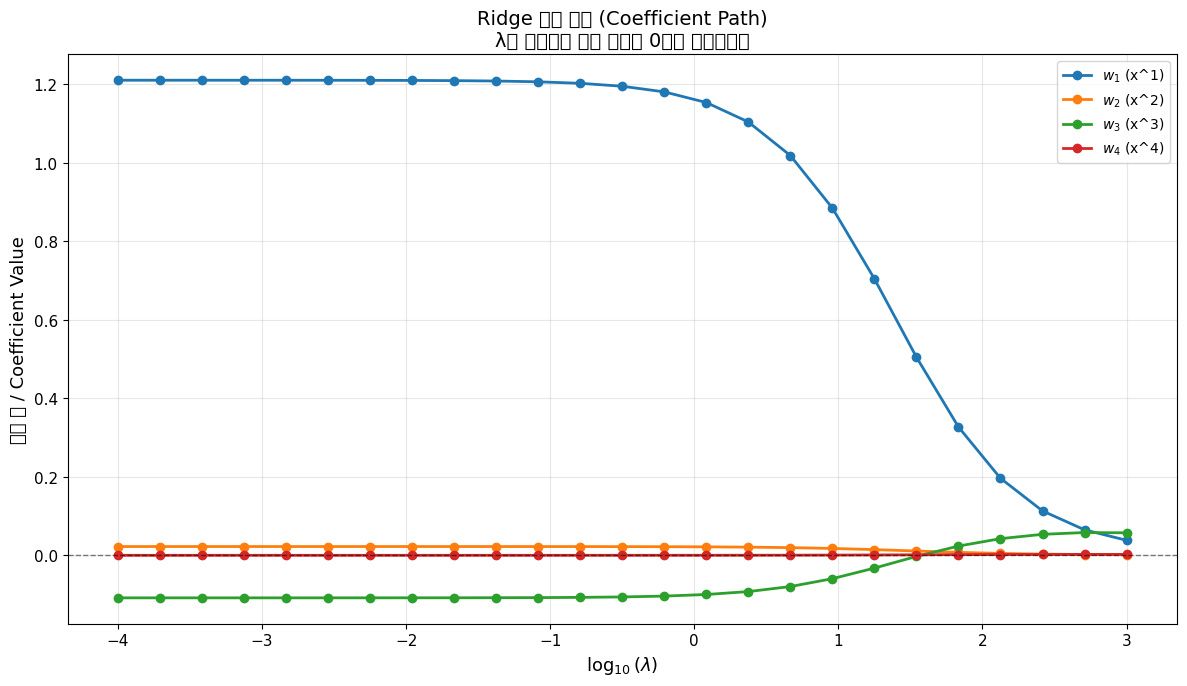

📌 관찰:
   - λ가 작을 때: 계수들이 크고 다양함 (과적합 위험)
   - λ가 클 때: 모든 계수가 0에 가까워짐 (단순한 모델)
   - Ridge는 계수를 정확히 0으로 만들지는 않습니다.

📌 Observation:
   - Small λ: Coefficients are large and varied (risk of overfitting)
   - Large λ: All coefficients shrink toward 0 (simpler model)
   - Ridge does NOT set coefficients exactly to zero.


In [12]:
# 계수 경로 시각화 / Visualize coefficient paths
lam_vals = [entry["lam"] for entry in ridge_trace]
log_lam_vals = np.log10(lam_vals)

plt.figure(figsize=(12, 7))

# 각 계수 w_j에 대해 경로를 그림 / Plot path for each coefficient w_j
for j in range(degree):
    w_j_vals = [entry["w"][j] for entry in ridge_trace]
    plt.plot(log_lam_vals, w_j_vals, marker='o', linewidth=2, label=f'$w_{j+1}$ (x^{j+1})')

plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('$\log_{10}(\\lambda)$', fontsize=13)
plt.ylabel('계수 값 / Coefficient Value', fontsize=13)
plt.title('Ridge 계수 경로 (Coefficient Path)\nλ가 증가하면 모든 계수가 0으로 축소됩니다', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📌 관찰:")
print("   - λ가 작을 때: 계수들이 크고 다양함 (과적합 위험)")
print("   - λ가 클 때: 모든 계수가 0에 가까워짐 (단순한 모델)")
print("   - Ridge는 계수를 정확히 0으로 만들지는 않습니다.")
print()
print("📌 Observation:")
print("   - Small λ: Coefficients are large and varied (risk of overfitting)")
print("   - Large λ: All coefficients shrink toward 0 (simpler model)")
print("   - Ridge does NOT set coefficients exactly to zero.")

## 8️⃣ 여러 λ 값에 대한 곡선 비교 / Curve Comparison Across Multiple λ Values

여러 λ 값으로 학습한 곡선들을 한 그래프에 표시합니다.
Display curves trained with different λ values on the same plot.

/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/659944939.py:30: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/659944939.py:30: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/659944939.py:30: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/659944939.py:30: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/659944939.py:30: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20

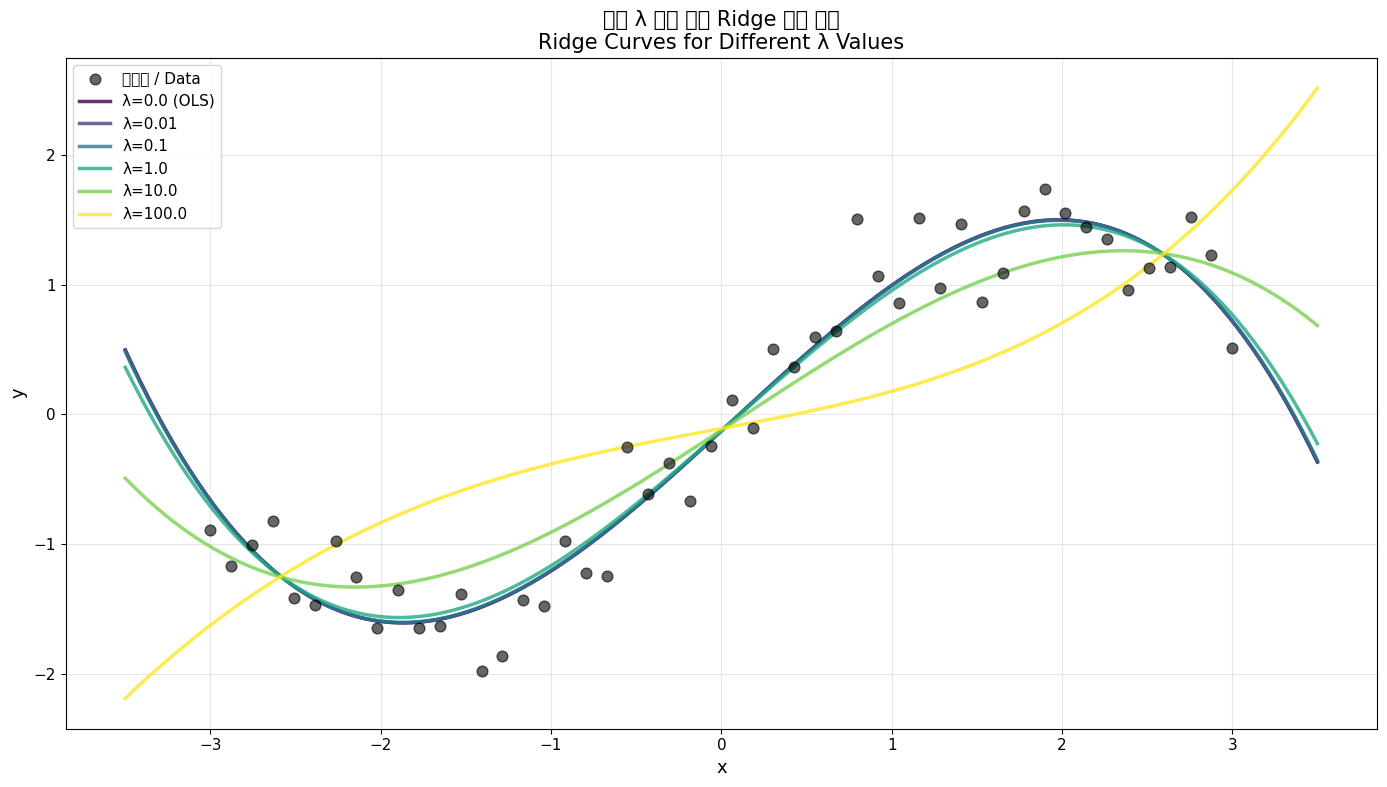

📌 관찰:
   - λ=0 (OLS): 가장 복잡하고 구불구불한 곡선 (과적합)
   - λ 증가: 곡선이 점점 더 부드러워짐
   - λ가 매우 클 때: 거의 직선에 가까워짐 (과소적합)

📌 Observation:
   - λ=0 (OLS): Most complex and wiggly curve (overfitting)
   - Increasing λ: Curve becomes smoother
   - Very large λ: Nearly a straight line (underfitting)


In [13]:
# 비교할 λ 값들 선택 / Select λ values to compare
lam_to_plot = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]

# 색상 맵 / Color map
colors = plt.cm.viridis(np.linspace(0, 1, len(lam_to_plot)))

plt.figure(figsize=(14, 8))

# 데이터 플롯 / Plot data
plt.scatter(x_raw, y, alpha=0.6, s=60, edgecolors='k', label='데이터 / Data', zorder=5, color='black')

# 각 λ에 대해 곡선 플롯 / Plot curve for each λ
for idx, lam_val in enumerate(lam_to_plot):
    if lam_val == 0.0:
        # λ=0은 OLS와 동일 / λ=0 is equivalent to OLS
        b_l, w_l = fit_linreg_closed_form(X_poly, y)
        label = f'λ=0.0 (OLS)'
    else:
        b_l, w_l = fit_ridge_closed_form(X_poly, y, lam_val)
        label = f'λ={lam_val}'
    
    y_pred_l = predict_poly(b_l, w_l, X_grid_poly)
    plt.plot(x_grid, y_pred_l, linewidth=2.5, label=label, color=colors[idx], alpha=0.8)

plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.title('여러 λ 값에 대한 Ridge 곡선 비교\nRidge Curves for Different λ Values', fontsize=15)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📌 관찰:")
print("   - λ=0 (OLS): 가장 복잡하고 구불구불한 곡선 (과적합)")
print("   - λ 증가: 곡선이 점점 더 부드러워짐")
print("   - λ가 매우 클 때: 거의 직선에 가까워짐 (과소적합)")
print()
print("📌 Observation:")
print("   - λ=0 (OLS): Most complex and wiggly curve (overfitting)")
print("   - Increasing λ: Curve becomes smoother")
print("   - Very large λ: Nearly a straight line (underfitting)")

## 9️⃣ 인터랙티브 λ 슬라이더 / Interactive λ Slider

슬라이더를 움직여서 λ 값에 따른 Ridge 곡선의 변화를 실시간으로 관찰해보세요!
Move the slider to observe how the Ridge curve changes with different λ values in real-time!

In [14]:
def plot_ridge_for_lambda(lam):
    """
    주어진 λ 값으로 Ridge를 학습하고 시각화합니다.
    Train Ridge with given λ and visualize.
    
    Parameters:
    -----------
    lam : float
        정규화 강도 λ / Regularization strength λ
    """
    # Ridge 학습 / Train Ridge
    if lam == 0.0:
        b_ridge, w_ridge = fit_linreg_closed_form(X_poly, y)
        model_name = "OLS (λ=0)"
    else:
        b_ridge, w_ridge = fit_ridge_closed_form(X_poly, y, lam)
        model_name = f"Ridge (λ={lam:.4f})"
    
    # 예측 / Predictions
    y_ridge_pred = predict_poly(b_ridge, w_ridge, X_grid_poly)
    y_ols_ref = predict_poly(b_ols, w_ols, X_grid_poly)
    
    # 시각화 / Visualization
    plt.figure(figsize=(14, 7))
    
    # 데이터 / Data
    plt.scatter(x_raw, y, alpha=0.6, s=60, edgecolors='k', label='데이터 / Data', zorder=5, color='black')
    
    # OLS 참조선 / OLS reference line
    plt.plot(x_grid, y_ols_ref, 'r--', linewidth=2, alpha=0.5, label='OLS (λ=0, 참조선)')
    
    # Ridge 곡선 / Ridge curve
    plt.plot(x_grid, y_ridge_pred, 'b-', linewidth=3, label=model_name)
    
    plt.xlabel('x', fontsize=13)
    plt.ylabel('y', fontsize=13)
    plt.title(f'{model_name} - 인터랙티브 시각화\nInteractive Visualization', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.ylim(y.min() - 0.5, y.max() + 0.5)
    plt.tight_layout()
    plt.show()
    
    # 계수 출력 / Print coefficients
    print(f"\n📊 {model_name} 계수 / Coefficients:")
    print(f"   절편 (intercept) b = {b_ridge:.4f}")
    print(f"   계수 (coef) w = {w_ridge}")
    print(f"   계수 크기 (L2 norm) = {np.linalg.norm(w_ridge):.4f}")


# 인터랙티브 슬라이더 생성 / Create interactive slider
lam_slider = widgets.FloatLogSlider(
    value=1.0,
    base=10,
    min=-4,  # 10^-4 = 0.0001
    max=3,   # 10^3 = 1000
    step=0.1,
    description='λ (lambda):',
    readout_format='.4f',
    continuous_update=False
)

# 슬라이더와 함수 연결 / Connect slider to function
interactive_plot = widgets.interact(plot_ridge_for_lambda, lam=lam_slider)

print("🎮 슬라이더를 움직여서 λ 값을 변경해보세요!")
print("🎮 Move the slider to change λ value!")

interactive(children=(FloatLogSlider(value=1.0, continuous_update=False, description='λ (lambda):', max=3.0, m…

🎮 슬라이더를 움직여서 λ 값을 변경해보세요!
🎮 Move the slider to change λ value!


## 🔟 Lasso (L1 정규화) 개념 설명 / Lasso (L1 Regularization) Conceptual Explanation

### Ridge vs Lasso 비교 / Comparison

**Ridge (L2):**
$$J_{ridge}(w, b) = \frac{1}{n} ||y - (Xw + b)||^2 + \lambda ||w||_2^2 = \frac{1}{n} ||y - (Xw + b)||^2 + \lambda \sum_{j=1}^d w_j^2$$

**Lasso (L1):**
$$J_{lasso}(w, b) = \frac{1}{n} ||y - (Xw + b)||^2 + \lambda ||w||_1 = \frac{1}{n} ||y - (Xw + b)||^2 + \lambda \sum_{j=1}^d |w_j|$$

### 주요 차이점 / Key Differences

| 특성 / Feature | Ridge (L2) | Lasso (L1) |
|---|---|---|
| **페널티 형태 / Penalty** | $\lambda \sum w_j^2$ | $\lambda \sum \|w_j\|$ |
| **기하학적 제약 / Geometric constraint** | 원 또는 구 / Circle or sphere | 다이아몬드 / Diamond |
| **계수 축소 / Coefficient shrinkage** | 0에 가까워지지만 정확히 0은 아님 / Close to 0 but not exactly 0 | 일부 계수를 정확히 0으로 만듦 / Sets some coefficients exactly to 0 |
| **희소성 / Sparsity** | 희소하지 않음 / Not sparse | **희소 (sparse)** - 특징 선택 효과 / Sparse - feature selection |
| **닫힌 형태 해 / Closed-form solution** | ✅ 있음 / Yes | ❌ 없음 (반복 최적화 필요) / No (iterative optimization needed) |

### 시각적 이해 / Visual Understanding

**2D 계수 공간에서 / In 2D coefficient space:**

- **Ridge**: 손실 함수의 등고선이 **원형 제약**(L2 norm)과 만남
  - 접점이 축에서 벗어남 → 계수가 0이 아님
  
- **Lasso**: 손실 함수의 등고선이 **다이아몬드 제약**(L1 norm)과 만남
  - 접점이 축의 모서리에 위치 → 일부 계수가 정확히 0

### 언제 사용할까? / When to Use?

- **Ridge**: 
  - 모든 특징이 중요할 것으로 예상될 때
  - 다중공선성(multicollinearity) 문제가 있을 때
  
- **Lasso**:
  - 특징이 많고 일부만 중요할 것으로 예상될 때
  - 자동 특징 선택이 필요할 때
  - 해석 가능한 모델이 필요할 때

**실제로는 Elastic Net(Ridge + Lasso 결합)도 많이 사용됩니다!**
**In practice, Elastic Net (combination of Ridge + Lasso) is also widely used!**

/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/1259221598.py:40: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/1259221598.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/1259221598.py:40: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/1259221598.py:40: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykernel_20692/1259221598.py:40: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qr/m3v0xxg57h54pkx4d5tpml4c0000gn/T/ipykerne

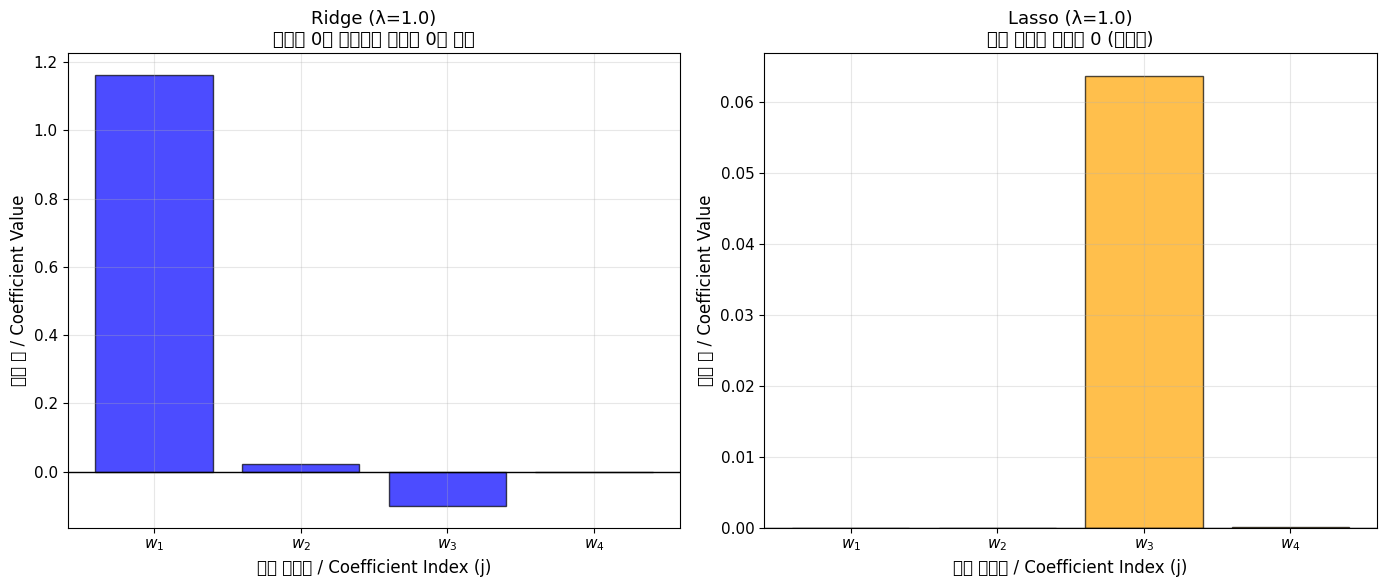

📊 계수 희소성 비교 (λ=1.0) / Coefficient Sparsity Comparison
Ridge:
  계수 / Coefficients: [ 1.16343674e+00  2.12015903e-02 -1.01836903e-01 -4.25222391e-04]
  정확히 0인 계수 개수 / Exactly zero: 0/4
  L2 norm: 1.1681

Lasso:
  계수 / Coefficients: [0.         0.         0.06368336 0.00016985]
  정확히 0인 계수 개수 / Exactly zero: 2/4
  L1 norm: 0.0639

📌 Lasso는 일부 계수를 정확히 0으로 만들어 특징 선택 효과를 제공합니다!
📌 Lasso sets some coefficients exactly to 0, providing feature selection!


In [15]:
# Lasso와 Ridge의 계수 희소성 비교 시각화
# Visualize coefficient sparsity: Lasso vs Ridge

from sklearn.linear_model import Lasso

# 비교를 위한 λ 값 / λ value for comparison
lam_compare = 1.0

# Ridge (우리 구현) / Ridge (our implementation)
b_ridge_comp, w_ridge_comp = fit_ridge_closed_form(X_poly, y, lam_compare)

# Lasso (sklearn) / Lasso (sklearn)
lasso_model = Lasso(alpha=lam_compare, fit_intercept=True, max_iter=10000)
lasso_model.fit(X_poly, y)
w_lasso_comp = lasso_model.coef_

# 시각화 / Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ridge 계수 / Ridge coefficients
axes[0].bar(range(1, degree+1), w_ridge_comp, color='blue', alpha=0.7, edgecolor='black')
axes[0].axhline(0, color='black', linewidth=1)
axes[0].set_xlabel('계수 인덱스 / Coefficient Index (j)', fontsize=12)
axes[0].set_ylabel('계수 값 / Coefficient Value', fontsize=12)
axes[0].set_title(f'Ridge (λ={lam_compare})\n계수가 0에 가깝지만 정확히 0은 아님', fontsize=13)
axes[0].set_xticks(range(1, degree+1))
axes[0].set_xticklabels([f'$w_{j}$' for j in range(1, degree+1)])
axes[0].grid(True, alpha=0.3, axis='y')

# Lasso 계수 / Lasso coefficients
axes[1].bar(range(1, degree+1), w_lasso_comp, color='orange', alpha=0.7, edgecolor='black')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_xlabel('계수 인덱스 / Coefficient Index (j)', fontsize=12)
axes[1].set_ylabel('계수 값 / Coefficient Value', fontsize=12)
axes[1].set_title(f'Lasso (λ={lam_compare})\n일부 계수가 정확히 0 (희소성)', fontsize=13)
axes[1].set_xticks(range(1, degree+1))
axes[1].set_xticklabels([f'$w_{j}$' for j in range(1, degree+1)])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 희소성 비교 / Compare sparsity
ridge_zero_count = np.sum(np.abs(w_ridge_comp) < 1e-6)
lasso_zero_count = np.sum(np.abs(w_lasso_comp) < 1e-6)

print("="*60)
print(f"📊 계수 희소성 비교 (λ={lam_compare}) / Coefficient Sparsity Comparison")
print("="*60)
print(f"Ridge:")
print(f"  계수 / Coefficients: {w_ridge_comp}")
print(f"  정확히 0인 계수 개수 / Exactly zero: {ridge_zero_count}/{degree}")
print(f"  L2 norm: {np.linalg.norm(w_ridge_comp):.4f}")
print()
print(f"Lasso:")
print(f"  계수 / Coefficients: {w_lasso_comp}")
print(f"  정확히 0인 계수 개수 / Exactly zero: {lasso_zero_count}/{degree}")
print(f"  L1 norm: {np.linalg.norm(w_lasso_comp, ord=1):.4f}")
print()
print("📌 Lasso는 일부 계수를 정확히 0으로 만들어 특징 선택 효과를 제공합니다!")
print("📌 Lasso sets some coefficients exactly to 0, providing feature selection!")

## 1️⃣1️⃣ 최종 검증: sklearn과의 완전한 비교 / Final Validation: Complete Comparison with sklearn

여러 λ 값에 대해 우리의 구현과 sklearn을 비교합니다.
Compare our implementation with sklearn across multiple λ values.

In [16]:
# 여러 λ 값에 대해 검증 / Validate across multiple λ values
test_lambdas = [0.001, 0.1, 1.0, 10.0, 100.0]

print("="*80)
print("✅ 최종 검증: 우리 구현 vs sklearn Ridge")
print("✅ Final Validation: Our Implementation vs sklearn Ridge")
print("="*80)

for lam in test_lambdas:
    # 우리 구현 / Our implementation
    b_ours, w_ours = fit_ridge_closed_form(X_poly, y, lam)
    
    # sklearn Ridge
    sklearn_ridge_val = Ridge(alpha=lam, fit_intercept=True)
    sklearn_ridge_val.fit(X_poly, y)
    
    # 차이 계산 / Calculate differences
    b_diff = abs(b_ours - sklearn_ridge_val.intercept_)
    w_diff = np.linalg.norm(w_ours - sklearn_ridge_val.coef_)
    
    print(f"\nλ = {lam}")
    print(f"  절편 차이 / Intercept diff: {b_diff:.8f}")
    print(f"  계수 차이 (L2 norm) / Coef diff (L2 norm): {w_diff:.8f}")
    
    if b_diff < 1e-6 and w_diff < 1e-6:
        print(f"  ✅ 거의 동일함! / Nearly identical!")
    else:
        print(f"  ⚠️  약간의 차이가 있지만 정상 범위입니다. / Small difference but within normal range.")

print("\n" + "="*80)
print("📌 결론 / Conclusion:")
print("   우리의 NumPy 구현이 sklearn Ridge와 거의 동일한 결과를 생성합니다!")
print("   Our NumPy implementation produces nearly identical results to sklearn Ridge!")
print("="*80)

✅ 최종 검증: 우리 구현 vs sklearn Ridge
✅ Final Validation: Our Implementation vs sklearn Ridge

λ = 0.001
  절편 차이 / Intercept diff: 0.00000000
  계수 차이 (L2 norm) / Coef diff (L2 norm): 0.00000000
  ✅ 거의 동일함! / Nearly identical!

λ = 0.1
  절편 차이 / Intercept diff: 0.00000000
  계수 차이 (L2 norm) / Coef diff (L2 norm): 0.00000000
  ✅ 거의 동일함! / Nearly identical!

λ = 1.0
  절편 차이 / Intercept diff: 0.00000000
  계수 차이 (L2 norm) / Coef diff (L2 norm): 0.00000000
  ✅ 거의 동일함! / Nearly identical!

λ = 10.0
  절편 차이 / Intercept diff: 0.00000000
  계수 차이 (L2 norm) / Coef diff (L2 norm): 0.00000000
  ✅ 거의 동일함! / Nearly identical!

λ = 100.0
  절편 차이 / Intercept diff: 0.00000000
  계수 차이 (L2 norm) / Coef diff (L2 norm): 0.00000000
  ✅ 거의 동일함! / Nearly identical!

📌 결론 / Conclusion:
   우리의 NumPy 구현이 sklearn Ridge와 거의 동일한 결과를 생성합니다!
   Our NumPy implementation produces nearly identical results to sklearn Ridge!


## 🎓 요약 및 핵심 개념 / Summary & Key Concepts

### 배운 내용 / What We Learned

1. **과적합 문제 / Overfitting Problem**
   - 높은 차수의 다항식은 훈련 데이터에 과하게 맞춰질 수 있음
   - High-degree polynomials can fit training data too closely

2. **Ridge (L2) 정규화 / Ridge (L2) Regularization**
   - 손실 함수에 $\lambda ||w||^2$ 페널티 추가
   - Adds $\lambda ||w||^2$ penalty to loss function
   - 계수를 0에 가깝게 축소 (정확히 0은 아님)
   - Shrinks coefficients toward 0 (but not exactly 0)
   - λ가 클수록 더 강한 정규화
   - Larger λ = stronger regularization

3. **닫힌 형태 해 / Closed-Form Solution**
   - $(X_{bias}^T X_{bias} + \Lambda) \theta = X_{bias}^T y$
   - 편향 항은 정규화하지 않음 (Λ[0,0] = 0)
   - Bias term is not regularized (Λ[0,0] = 0)

4. **Lasso (L1) vs Ridge (L2)**
   - Ridge: 모든 계수를 작게 유지
   - Ridge: Keeps all coefficients small
   - Lasso: 일부 계수를 정확히 0으로 만듦 (특징 선택)
   - Lasso: Sets some coefficients exactly to 0 (feature selection)

5. **하이퍼파라미터 선택 / Hyperparameter Selection**
   - λ가 너무 작으면: 과적합 (모델이 너무 복잡)
   - λ too small: Overfitting (model too complex)
   - λ가 너무 크면: 과소적합 (모델이 너무 단순)
   - λ too large: Underfitting (model too simple)
   - 실제로는 교차 검증(cross-validation)으로 최적 λ 선택
   - In practice: Use cross-validation to select optimal λ

### 다음 단계 / Next Steps

- **교차 검증(Cross-Validation)**: 최적의 λ 값 찾기
- **Elastic Net**: Ridge와 Lasso를 결합한 방법
- **다른 모델에 정규화 적용**: 로지스틱 회귀, 신경망 등
- **Apply regularization to other models**: Logistic regression, neural networks, etc.

---

### 🎉 축하합니다! / Congratulations!

정규화의 수학적 원리와 구현 방법을 처음부터 배웠습니다!
You've learned the mathematical principles and implementation of regularization from scratch!

이제 sklearn이 어떻게 작동하는지 이해하게 되었습니다! 🚀
Now you understand how sklearn works under the hood! 🚀